# Lab #7: Non-Linear Models for Regression
## AM 207: Advanced Scientific Computing
### Stochastic Methods for Data Analysis, Inference and Optimization
### Fall, 2019

<img src="fig/logos.jpg" style="height:150px;">

In [12]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from autograd import scipy as sp
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import sys
%matplotlib inline

In [2]:
class Feedforward:
    def __init__(self, architecture, random=None, weights=None):
        self.params = {'H': architecture['width'],
                       'L': architecture['hidden_layers'],
                       'D_in': architecture['input_dim'],
                       'D_out': architecture['output_dim'],
                       'activation_type': architecture['activation_fn_type'],
                       'activation_params': architecture['activation_fn_params']}

        self.D = (  (architecture['input_dim'] * architecture['width'] + architecture['width'])
                  + (architecture['output_dim'] * architecture['width'] + architecture['output_dim'])
                  + (architecture['hidden_layers'] - 1) * (architecture['width']**2 + architecture['width'])
                 )

        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)

        self.h = architecture['activation_fn']

        if weights is None:
            self.weights = self.random.normal(0, 1, size=(1, self.D))
        else:
            self.weights = weights

        self.objective_trace = np.empty((1, 1))
        self.weight_trace = np.empty((1, self.D))


    def forward(self, weights, x):
        ''' Forward pass given weights and input '''
        H = self.params['H']
        D_in = self.params['D_in']
        D_out = self.params['D_out']

        assert weights.shape[1] == self.D

        if len(x.shape) == 2:
            assert x.shape[0] == D_in
            x = x.reshape((1, D_in, -1))
        else:
            assert x.shape[1] == D_in

        weights = weights.T


        #input to first hidden layer
        W = weights[:H * D_in].T.reshape((-1, H, D_in))
        b = weights[H * D_in:H * D_in + H].T.reshape((-1, H, 1))
        input = self.h(np.matmul(W, x) + b)
        index = H * D_in + H

        assert input.shape[1] == H

        #additional hidden layers
        for _ in range(self.params['L'] - 1):
            before = index
            W = weights[index:index + H * H].T.reshape((-1, H, H))
            index += H * H
            b = weights[index:index + H].T.reshape((-1, H, 1))
            index += H
            output = np.matmul(W, input) + b
            input = self.h(output)

            assert input.shape[1] == H

        #output layer
        W = weights[index:index + H * D_out].T.reshape((-1, D_out, H))
        b = weights[index + H * D_out:].T.reshape((-1, D_out, 1))
        output = np.matmul(W, input) + b
        assert output.shape[1] == self.params['D_out']

        return output

    def make_objective(self, x_train, y_train, reg_param=None):
        ''' Make objective functions: depending on whether or not you want to apply l2 regularization '''
        
        if reg_param is None:
            
            def objective(W, t):
                squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1)**2
                sum_error = np.sum(squared_error)
                return sum_error
            
            return objective, grad(objective)
            
        else:
            
            def objective(W, t):
                squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1)**2
                mean_error = np.mean(squared_error) + reg_param * np.linalg.norm(W)
                return mean_error
            
            return objective, grad(objective)

    def fit(self, x_train, y_train, params, reg_param=None):
        ''' Wrapper for MLE through gradient descent '''
        assert x_train.shape[0] == self.params['D_in']
        assert y_train.shape[0] == self.params['D_out']

        ### make objective function for training
        self.objective, self.gradient = self.make_objective(x_train, y_train, reg_param)

        ### set up optimization
        step_size = 0.01
        max_iteration = 5000
        check_point = 100
        weights_init = self.weights.reshape((1, -1))
        mass = None
        optimizer = 'adam'
        random_restarts = 5

        if 'step_size' in params.keys():
            step_size = params['step_size']
        if 'max_iteration' in params.keys():
            max_iteration = params['max_iteration']
        if 'check_point' in params.keys():
            self.check_point = params['check_point']
        if 'init' in params.keys():
            weights_init = params['init']
        if 'call_back' in params.keys():
            call_back = params['call_back']
        if 'mass' in params.keys():
            mass = params['mass']
        if 'optimizer' in params.keys():
            optimizer = params['optimizer']
        if 'random_restarts' in params.keys():
            random_restarts = params['random_restarts']

        def call_back(weights, iteration, g):
            ''' Actions per optimization step '''
            objective = self.objective(weights, iteration)
            self.objective_trace = np.vstack((self.objective_trace, objective))
            self.weight_trace = np.vstack((self.weight_trace, weights))
            if iteration % check_point == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(iteration, objective, np.linalg.norm(self.gradient(weights, iteration))))

        ### train with random restarts
        optimal_obj = 1e16
        optimal_weights = self.weights

        for i in range(random_restarts):
            if optimizer == 'adam':
                adam(self.gradient, weights_init, step_size=step_size, num_iters=max_iteration, callback=call_back)
            local_opt = np.min(self.objective_trace[-100:])
            
            if local_opt < optimal_obj:
                opt_index = np.argmin(self.objective_trace[-100:])
                self.weights = self.weight_trace[-100:][opt_index].reshape((1, -1))
            weights_init = self.random.normal(0, 1, size=(1, self.D))

        self.objective_trace = self.objective_trace[1:]
        self.weight_trace = self.weight_trace[1:]

## Problem Description: Non-linear Models for Regression

From Lecture #14, we've seen that we can take our favourite generalized linear models and replace the linear function $\mathbf{w}^\top \mathbf{X}$ with $g_{\mathbf{W}}(\mathbf{X})$, where $g_{\mathbf{W}}$ is a neural network with parameters $\mathbf{W}$. The advantage of using neural networks to represent non-linear function is that neural networks allows us to build up complex non-linear functions very cheaply and quicklly through composition of simple functions. A neural network $g_{\mathbf{W}}$ with a fixed architecture can approximate a wide range of different functions.

In this lab, we compare fitting neural networks regression models with polynomial regression models.

### Part I. Small Data Set
Read in the data in `lab_7_data.csv` (this is the same dataset used in HW#7). 

1. (**Learning the Model**) Fit 100 different MLE neural network models (with the given architecture or your own choice) on this data. The data is small so don't bootstrap, rather, initialize your network parameters randomly for each fit. <br><br>

2. (**Model Evaluation**) Compute the average log-likelihood of the observed data over these 1000 MLE models.<br><br>

3. (**Model Evaluation**) Visualize the predictive distributions of your 1000 MLE models (i.e. use them to predict on a range of uniformly spaced values from [-8, 8] and then plot either the 95% predictive interval or plot all the models as lines).<br><br>

4. (**Compare with Polynomial Regression**) Do the above for polynomial models with polynomial degree 7. Which model class (polynomial or neural network) is a better fit for the data? Which model class produces better aleotoric uncertainty? Which model class prodcues better epistemic uncertainty? Why?

In [5]:
data = pd.read_csv('lab_7_data.csv')
x = data['x'].values
y = data['y'].values
data.head()

,x,y
0,-6.0,-3.380284
1,-5.6,-2.892117
2,-5.2,-2.690059
3,-4.8,-2.040000
4,-4.4,-1.399942


In [6]:
###define rbf activation function
alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c)**2)

###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=random)

In [9]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':2000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
nn.fit(x.reshape((1, -1)), y.reshape((1, -1)), params)

Iteration 0 lower bound 10.458036056339319; gradient mag: 8.331286747509058
Iteration 100 lower bound 9.401964473087148; gradient mag: 7.798951272971812
Iteration 200 lower bound 8.519613676681958; gradient mag: 6.991983137446767
Iteration 300 lower bound 7.719876546264666; gradient mag: 6.355351943121808
Iteration 400 lower bound 6.981694524465028; gradient mag: 5.828105307474688
Iteration 500 lower bound 6.295826462275024; gradient mag: 5.377383515100863
Iteration 600 lower bound 5.6589728727700965; gradient mag: 4.980024913762885
Iteration 700 lower bound 5.070646187376429; gradient mag: 4.620498212409427
Iteration 800 lower bound 4.531128446519426; gradient mag: 4.288850388700083
Iteration 900 lower bound 4.04055632605758; gradient mag: 3.9782656449273297
Iteration 1000 lower bound 3.5984545183993455; gradient mag: 3.684752651916061
Iteration 1100 lower bound 3.2036370710760074; gradient mag: 3.40563008365816
Iteration 1200 lower bound 2.8542767567518164; gradient mag: 3.1385689741

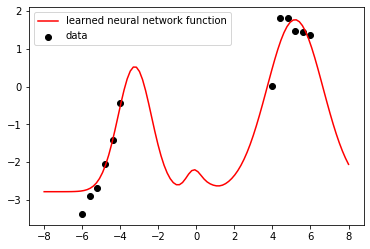

In [10]:
x_test = np.linspace(-8, 8, 100)

#predict on x_test
y_test = nn.forward(nn.weights, x_test.reshape((1, -1)))

#visualize our learned model
plt.scatter(x, y, color='black', label='data')
plt.plot(x_test, y_test.flatten(), color='red', label='learned neural network function')
plt.legend(loc='best')
plt.show()

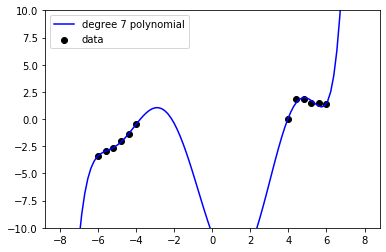

In [16]:
#set up for polynomial (deg 7) regression
linear_model = LinearRegression()
poly = PolynomialFeatures(7)

#fit a polynomial model
x_poly = poly.fit_transform(x.reshape((-1, 1)))
x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))
linear_model.fit(x_poly, y)

#predict on x_test
y_test_poly = linear_model.predict(x_test_poly)

#visualize our learned model
plt.scatter(x, y, color='black', label='data')
plt.plot(x_test, y_test_poly.flatten(), color='blue', label='degree 7 polynomial')
plt.legend(loc='best')
plt.ylim([-10, 10])
plt.show()

### Part II. "Large" Data Set
Using the data that is generated by the code provided below.

1. (**Learning the Model**) Fit 100 different MLE neural network models (with the given architecture or your own choice) on this data. Bootstrap from the data as well as initialize your network parameters randomly for each fit. <br><br>

2. (**Model Evaluation**) Compute the average log-likelihood of the observed data over these 1000 MLE models.<br><br>

3. (**Model Evaluation**) Visualize the predictive distributions of your 1000 MLE models (i.e. use them to predict on a range of uniformly spaced values from [-11, 11] and then plot either the 95% predictive interval or plot all the models as lines).<br><br>

4. (**Compare with Polynomial Regression**) Do the above for polynomial models with polynomial degree 7. Which model class (polynomial or neural network) is a better fit for the data? Which model class produces better aleotoric uncertainty? Which model class prodcues better epistemic uncertainty? Why?

In [17]:
## generate training data
#number of points in each of the two segments of the domain
N = 100
#training x
x = np.hstack((np.linspace(-10, -5, N), np.linspace(5, 10, N)))
#output noise variance
y_var = 1.0
#function relating x and y
f = lambda x:  0.01 * x**3
#y is equal to f(x) plus gaussian noise
y = f(x) + np.random.normal(0, y_var**0.5, 2 * N)

In [25]:
###define design choices in gradient descent
params = {'step_size':1e-2, 
          'max_iteration':5000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
nn.fit(x.reshape((1, -1)), y.reshape((1, -1)), params)

Iteration 0 lower bound 225.4945532381938; gradient mag: 199.48252171570954
Iteration 100 lower bound 225.31461527245983; gradient mag: 147.1343331669715
Iteration 200 lower bound 225.05092125743857; gradient mag: 4.038438194244029
Iteration 300 lower bound 224.75300726258823; gradient mag: 4.270025680356077
Iteration 400 lower bound 224.43448641919886; gradient mag: 3.9384245779736733
Iteration 500 lower bound 224.1073820135814; gradient mag: 3.618215598837167
Iteration 600 lower bound 223.77912120989896; gradient mag: 3.3177131543902147
Iteration 700 lower bound 223.45354632615187; gradient mag: 3.0505606839846684
Iteration 800 lower bound 223.13218288626967; gradient mag: 2.819689489377393
Iteration 900 lower bound 222.81527402114364; gradient mag: 2.6224146956681227
Iteration 1000 lower bound 222.50247309692182; gradient mag: 2.45405083422702
Iteration 1100 lower bound 222.19326208946063; gradient mag: 2.3095173756863336
Iteration 1200 lower bound 221.88717783564937; gradient mag: 

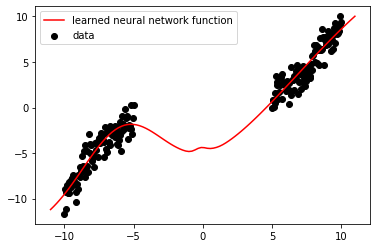

In [26]:
x_test = np.linspace(-11, 11, 100)

#predict on x_test
y_test = nn.forward(nn.weights, x_test.reshape((1, -1)))

#visualize our learned model
plt.scatter(x, y, color='black', label='data')
plt.plot(x_test, y_test.flatten(), color='red', label='learned neural network function')
plt.legend(loc='best')
plt.show()

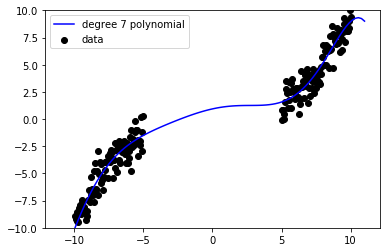

In [27]:
#set up for polynomial (deg 7) regression
linear_model = LinearRegression()
poly = PolynomialFeatures(7)

#fit a polynomial model
x_poly = poly.fit_transform(x.reshape((-1, 1)))
x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))
linear_model.fit(x_poly, y)

#predict on x_test
y_test_poly = linear_model.predict(x_test_poly)

#visualize our learned model
plt.scatter(x, y, color='black', label='data')
plt.plot(x_test, y_test_poly.flatten(), color='blue', label='degree 7 polynomial')
plt.legend(loc='best')
plt.ylim([-10, 10])
plt.show()